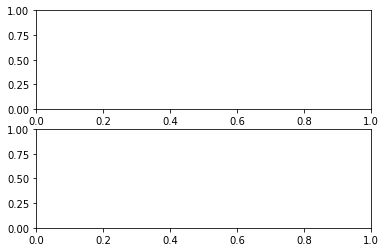

In [100]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pickle
from sklearn import cluster
from sklearn import metrics

from sympy.solvers import solve
import sympy as sym

from scipy import optimize

class VelocityPlotter():
    def __init__(self):
        personNames = ['person1','person2','person3', 'person4','person5','person6']
        colors = ['red', 'green', 'orange', 'cyan', 'magenta', 'black']

        picklesToLoad = ['person1.pickle', 'person2.pickle','person3.pickle', 'person4.pickle', 'person5.pickle', 'person6.pickle']
        startTimes = [[26.8, 382, 483.3], #person1
            [3.6, 352, 446.75], # person2
            [9.5, 378, 481.25], # person3
            [35.1, 436, 543], #person4
            [10.8, 387, 500], # person5
            [12.1, 364, 458.25], #person6
            ]

        dataSets = []
        for pickleToLoad in picklesToLoad:
            data = pickle.load(open(pickleToLoad, 'rb'))
            dataSets.append(data)

        newDataset = [[[] for _ in range(4)] for _ in range(len(dataSets))]
        for i, dataSet in enumerate(dataSets):
            x_log, distance_to_spot_log, time_log_angle, time_log_filter, spot_v_log, time_log_spot = dataSet
            for data in zip(x_log, distance_to_spot_log, time_log_angle, time_log_filter):
                if data[3] > startTimes[i][1]:
                    newDataset[i][0].append(data[0])
                    newDataset[i][1].append(data[1])
                    newDataset[i][2].append(data[2])
                    newDataset[i][3].append(data[3])
        self.all_distance = []
        self.all_vel = []
        self.all_angles = []

        #fig2, ax2 = plt.subplots(1)

        for j, dataSet in enumerate(newDataset):
            x_log, distance_to_spot_log, time_log_angle, time_log_filter = dataSet

            #fig, ax = plt.subplots(1)
            for i in range(len(time_log_angle)):
                time_log_angle[i] = (time_log_angle[i]-np.pi) * (180/np.pi)

            person_velocity = []
            for i in range(len(x_log)):
                person_velocity.append( np.linalg.norm( np.array(x_log[i])[3:5] ) )

            bool_array = np.array(person_velocity) > 0.25
            person_velocity = list(np.array(person_velocity)[bool_array == True])
            distance_to_spot_log = list(np.array(distance_to_spot_log)[bool_array == True])
            time_log_angle = list(np.array(time_log_angle)[bool_array == True])
            time_log_filter = list(np.array(time_log_filter)[bool_array == True])

            #print(len(distance_to_spot_log))
            #print(len(time_log_angle))
            #print(len(time_log_filter))

            self.all_distance = self.all_distance + distance_to_spot_log
            self.all_vel = self.all_vel  + person_velocity
            self.all_angles = self.all_angles + time_log_angle

            filter = np.array(distance_to_spot_log) < 3.5
            coefs = np.polyfit(np.array(person_velocity)[filter == True], np.array(distance_to_spot_log)[filter == True], 2)

            # X = np.arange(0.1, 1.4, 0.1)
            # ax.plot(X, np.polyval(coefs, X), color="black")
            # ax.plot(np.array(person_velocity)[filter == True], np.array(distance_to_spot_log)[filter == True], 'o', label=personNames[j], color=colors[j])
            # ax.set_ylabel('Distance to Spot [m]')
            # ax.set_xlabel('Speed [m/s]')
            # ax.legend()
            # ax.set_ylim([0.5, 3.5])

            # ax2.plot(np.array(person_velocity)[filter == True], np.array(distance_to_spot_log)[filter == True], 'o', markersize=1, label=personNames[j], color=colors[j])
            # ax2.set_ylabel('Distance to Spot [m]')
            # ax2.set_xlabel('Speed [m/s]')
            # ax2.legend()
            # ax2.set_ylim([0.5, 3.5])
            #print("dist:" ,personNames[j], np.median(distance_to_spot_log))
            #print("angle:" ,personNames[j], np.median(time_log_angle))


        #fig, ax3 = plt.subplots(1)
        self.X = np.arange(0, 1.5, 0.1)
        self.Y = np.arange(0, 3.5, 0.1)

        filter = np.array(self.all_distance) < 3.5
        coefs = np.polyfit(np.array(self.all_vel)[filter == True], np.array(self.all_distance)[filter == True], 1)
        self.coefs = coefs
        self.filtered = (np.array(self.all_vel)[filter == True], np.array(self.all_distance)[filter == True])
        #ax2.plot(X, np.polyval(coefs, X), color="black")

        fig2, ax5 = plt.subplots(2)

        def point_on_curve(x0, y0):
            x_min = sym.Symbol('x')
            mean = np.polyval(coefs, x_min)
            the_diff = sym.diff( sym.sqrt( (x_min - x0)**2 + (mean - y0)**2 ), x_min )
            return_var = solve(the_diff, x_min)
            return float(sym.re(return_var[0])), float(sym.re(np.polyval(coefs, return_var[0])))

        def equation(x):
            x_min, y_min = point_on_curve(x[0], x[1])

            distance = sym.sqrt( (x_min - x[0])**2 + (y_min - x[1])**2 )#

            x1 = 1.4
            y1 = np.polyval(coefs, x1)

            arc_length = sym.sqrt((x1 - x_min)**2 + (y1 - y_min)**2)
            #print(x)
            #print(sym.re(distance + arc_length))
            return float(sym.re(distance + arc_length))

        def func3d(x0, y0):
            x2, y2 = point_on_curve(x0, y0)
            dist = sym.sqrt( (x2 - x0)**2 + (y2 - y0)**2 )

            x1 = 1.4
            y1 = np.polyval(coefs, x1)

            arc_length = np.linalg.norm([x1 - x2,
                                        y1 - y2])

            if float(sym.re(dist + arc_length)) < 0.2:
                return 0.2

            return float(sym.re(dist + arc_length))

        func3d_vectorized = np.vectorize(func3d, cache=True)
        X, Y = np.meshgrid(self.X, self.Y)
        self.Z = np.asfarray(func3d_vectorized(X, Y))


letsgoo = VelocityPlotter()

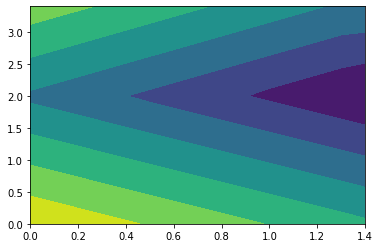

In [101]:
fig, ax3 = plt.subplots(1)
cm = plt.cm.get_cmap('viridis')
ax3.contourf(letsgoo.X, letsgoo.Y, letsgoo.Z)
ax3.plot(letsgoo.X, np.polyval(letsgoo.coefs, letsgoo.X))

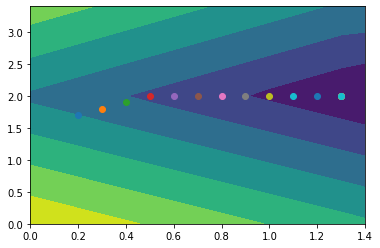

In [109]:
fig, ax3 = plt.subplots(1)
cm = plt.cm.get_cmap('viridis')
ax3.contourf(letsgoo.X, letsgoo.Y, letsgoo.Z)

x_i = 1
y_i = 16
Last_cost = letsgoo.Z[y_i, x_i]
iteration = 0
while True: #not (1.4 + 0.01 > letsgoo.X[x_i] > 1.4 - 0.01):
    iteration += 1
    if iteration > 20:
        break
    new_x = x_i
    new_y = y_i
    for x in range(-1, 2):
        for y in range(-1, 2):
            if letsgoo.Z[y_i + y, x_i + x] < Last_cost:
                new_x = x_i + x
                new_y = y_i + y
                Last_cost = letsgoo.Z[y_i + y, x_i + x]

    x_i = new_x
    y_i = new_y
    
    ax3.plot(letsgoo.X[x_i], letsgoo.Y[y_i], 'o')

In [103]:
print(np.polyfit(letsgoo.filtered[0], letsgoo.filtered[1], 1, full=True)[1] / len(letsgoo.filtered[0]))
print(np.polyfit(letsgoo.filtered[0], letsgoo.filtered[1], 2, full=True)[1] / len(letsgoo.filtered[0]))
print(np.polyfit(letsgoo.filtered[0], letsgoo.filtered[1], 3, full=True)[1] / len(letsgoo.filtered[0]))
print(np.polyfit(letsgoo.filtered[0], letsgoo.filtered[1], 4, full=True)[1] / len(letsgoo.filtered[0]))

[0.22691266]
[0.22469641]
[0.22469596]
[0.2204038]


In [104]:
import pickle

pickle.dump((letsgoo.X, letsgoo.Y, letsgoo.Z), open("gradients.pickle", "wb"))